**CN included trainset for LDA+XGB CoPath**

In [ ]:
import pandas as pd
import numpy as np
from data_processor import *
from lda_model import LDATopicModel
from classifier import TopicClassifier
from visualizer import *
from brain_visualizer import *

data_path = 'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data'

inp_df = pd.read_csv(os.path.join(data_path,'260128_wsev_smc_combined_cn_included.csv'))
inp_df = inp_df[inp_df['DX']!='HC'] # EXCLUDE WSEV HC

print(inp_df['DX'].value_counts())

df_nacc_resilience = pd.read_csv(data_path + '/nacc/NACC_resilience_inference.csv')
df_adni4_resilience = pd.read_csv(data_path + '/adni/ADNI4_resilience_inference.csv')
# df_nacc_resilience = pd.read_csv('C:/Users/BREIN/Desktop/stage_copath/20260122_NACC_linear_group.csv')

df_adni4_resilience = df_adni4_resilience.rename(columns={"FULL_ID": "SUBJ_ID"})
df_nacc_resilience = df_nacc_resilience.rename(columns={"subject_id" : "SUBJ_ID"})
nacc_raw = pd.read_csv(data_path + '/nacc/260120_NACC_VA_TAU_PATH_matched.csv')

In [ ]:
region_cols = nacc_raw.loc[:, 'VA/2':'VA/2035'].columns
# nacc_filtered = nacc_raw[nacc_raw['DX'] != 'Unknown']
# nacc_cn = nacc_filtered[nacc_filtered['DX'] == 'CN']

## DOWNSAMPLE LARGE DX 
N = 25
dx_col = "DX"
balanced_parts = []

for dx, g in inp_df.groupby(dx_col):
    if dx == 'AD':
        N=50
    elif dx == 'NC':
        N=50
    else: 
        N=25
    if len(g) > N:
        g = g.sample(n=N, replace=False, random_state=42)
    balanced_parts.append(g)

train_df = pd.concat(balanced_parts).reset_index(drop=True)


#### add mci to AD ####
# train_df['DX'] = train_df['DX'].replace({'MCI' : 'AD'})

print(train_df[dx_col].value_counts())

In [108]:
k = 18
print('K-topics = ', k)
labels = train_df["DX"].values
ids = train_df["SUBJ_ID"].values

lda = LDATopicModel(n_topics=k)
theta = lda.fit_transform(train_df[region_cols])
classifier = TopicClassifier(n_splits=5)
cv_results = classifier.cross_validate(theta, labels, ids, verbose=False)
classifier.fit(theta, labels)
print(f"k_topics {k}, CV ACC: {cv_results['accuracy']}")
print(lda._theta.shape)

K-topics =  18


c:\Users\WooSikKim\anaconda3\envs\data_management\lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\WooSikKim\anaconda3\envs\data_management\lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\WooSikKim\anaconda3\envs\data_management\lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


k_topics 18, CV ACC: 0.45564516129032256
(248, 18)


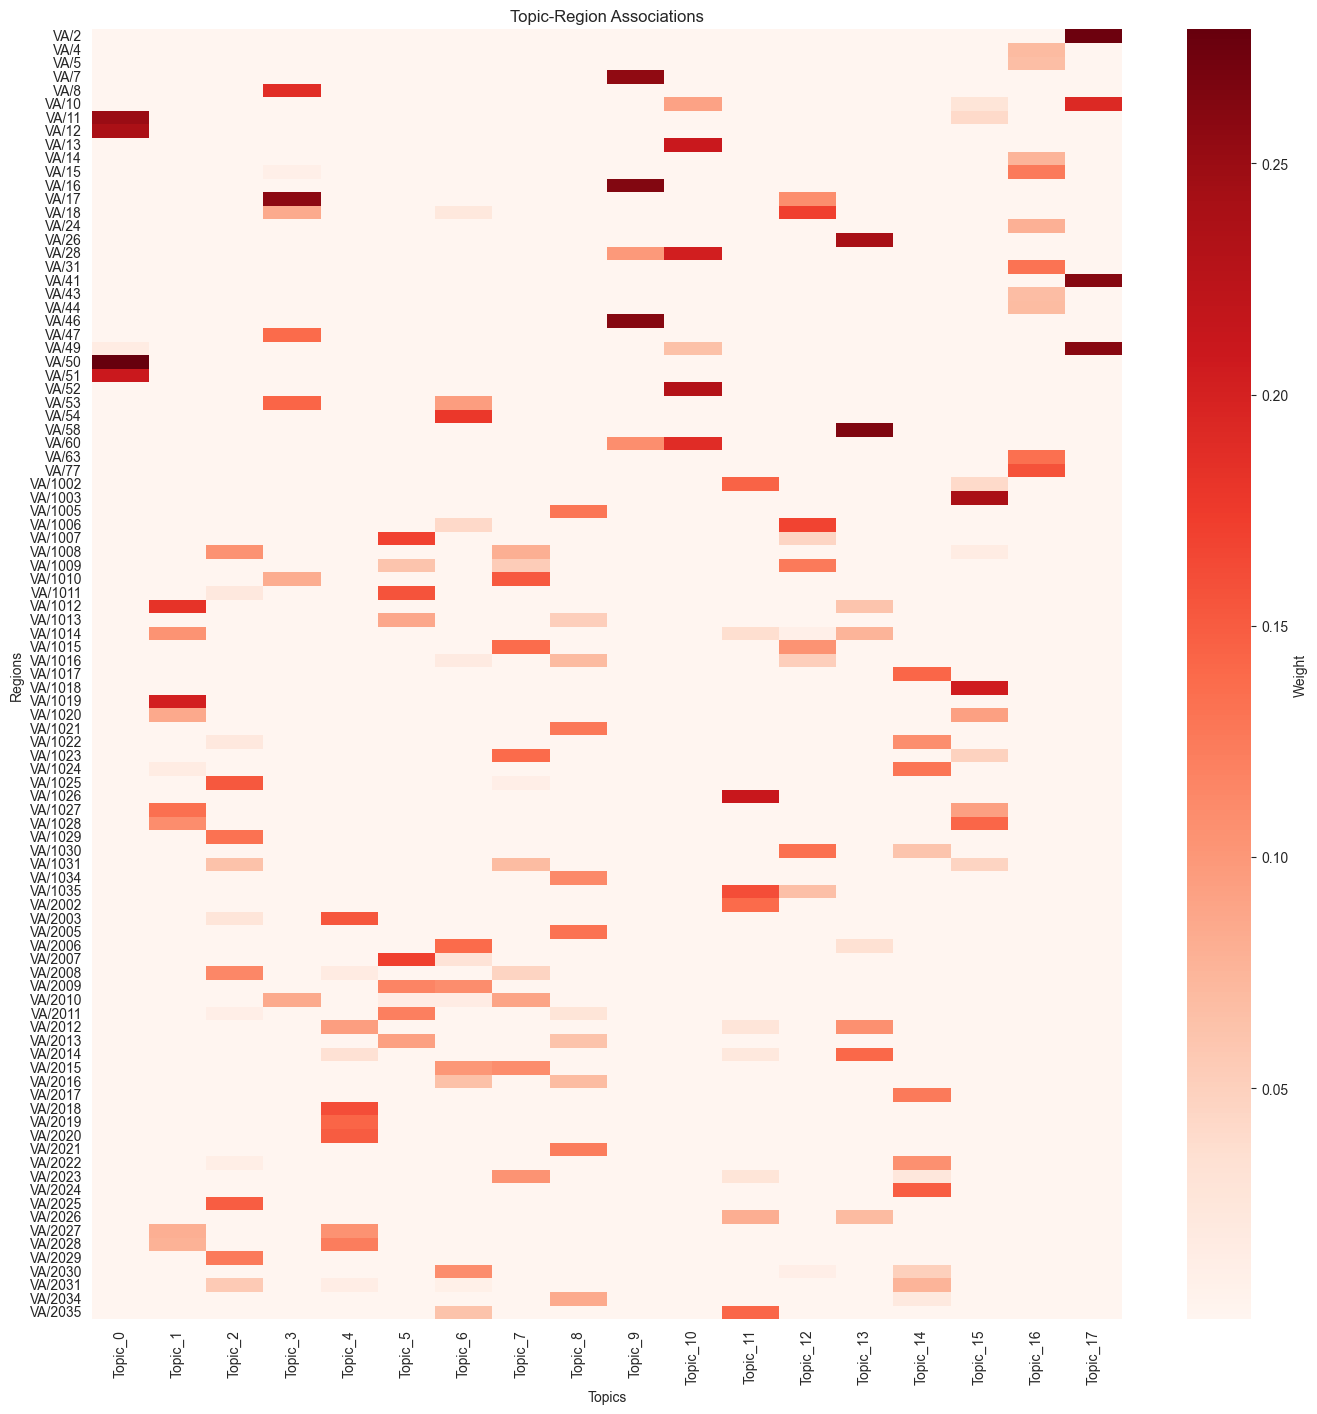

In [ ]:
## Internal Visualization
visualizer = CopathologyVisualizer(
    output_dir=f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/train_cn_added/topics_{k}_downsampled'
)
# fig_conf_mat = visualizer.plot_confusion_matrix(
#     cm=classifier.get_confusion_matrix(),
#     class_names=classifier._classes
# )

# fig_top_regions = visualizer.plot_top_regions_per_topic(
#     topic_patterns = lda.get_topic_patterns(),
#     region_names=region_cols
# )

# radar_plot = visualizer.plot_diagnosis_topic_profiles(
#     theta=lda._theta,
#     dx_labels = labels
# )

# probabilities_heatmap = visualizer.plot_probability_heatmap(
#     proba_df=classifier.get_cv_results(),
#     dx_order = ["NC", "AD", "DLB", "PD", "SVAD", "bvFTD", "nfvPPA", "svPPA"]
# )

In [ ]:
## Surface Mapping ##
from atlas_vis import DKTAtlas62ROIPlotter
plotter_62  = DKTAtlas62ROIPlotter(
    cmap='Reds',
    clim=(0, 0.1),  
    window_size=(1200, 1000),
    nan_color='lightgray',
    background='white',
    template_key='pial'
)
os.makedirs(f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/train_cn_added/topics_{k}_downsampled/topicwise',exist_ok=True)

topic_df = pd.DataFrame(
    lda.get_topic_patterns().T,
    index=region_cols,
    columns=[f"Topic_{k}" for k in range(k)]
)

df = topic_df.tail(62).reset_index(drop=True)

print(len(df))
for col in df.columns: ##################
    print(col)
    l_values = df.loc[:30,col].to_list()
    r_values = df.loc[31:,col].to_list()
    print(len(l_values))
    print(len(r_values))
    print(np.min(l_values+r_values))
    print(np.max(l_values+r_values))

    plotter_62(l_values, r_values, save_path=f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/train_cn_added/topics_{k}_downsampled/topicwise/{col}.png')

**NACC Inference**

In [105]:
# NACC CN included inference ##
nacc_raw = pd.read_csv(os.path.join(data_path, 'nacc/260120_NACC_VA_TAU_PATH_matched.csv'))
linear_resilience = pd.read_csv(os.path.join(data_path, 'nacc/20260122_NACC_linear_group.csv'))
region_cols = nacc_raw.loc[:, 'VA/2':'VA/2035'].columns
pathology_cols = nacc_raw.loc[:, 'NACC_AD':'NACC_svPPA'].columns
nacc_filtered = nacc_raw[nacc_raw['DX'] != 'Unknown']

nacc_cn = nacc_filtered[nacc_filtered['DX']=='CN']

print(nacc_cn.shape)
print(nacc_filtered.shape)

nacc_prep = DataProcessor(
    region_cols=region_cols,
    dx_col = 'DX',
    subject_col='subject_id'
)
nacc_prep.fit_baseline(hc_data=nacc_cn)
nacc_Z = nacc_prep.compute_atrophy_scores(data=nacc_filtered)
# print(type(nacc_Z))

nacc_theta = lda.transform(nacc_Z)
y_pred = classifier.predict(nacc_theta)
y_proba = classifier.predict_proba(nacc_theta)

nacc_results = pd.DataFrame(nacc_theta, columns=[f"Topic_{k}" for k in range(lda.n_topics)])
print(nacc_results.shape)
subj_col = nacc_prep.subject_col
if subj_col in nacc_filtered.columns:
    nacc_results.insert(0, "SUBJ_ID", nacc_filtered[subj_col].values)

nacc_results['pred_DX'] = y_pred
for i, dx in enumerate(classifier.classes):
    nacc_results[f"P({dx})"] = y_proba[:,i]
nacc_results = nacc_results.merge(
    linear_resilience[["FULL_ID", "linear_group", "standardized_residual"]],
    left_on="SUBJ_ID",
    right_on='FULL_ID',
    how="left"
)
nacc_results = nacc_results.dropna(subset=['linear_group'])
nacc_results = nacc_results.merge(
    nacc_raw[["subject_id", "DX", 'NACC_AD', 'NACC_PD', 'NACC_VD', 'NACC_LBD', 'NACC_SVAD', 'NACC_PCA', 'NACC_bvFTD']],
    left_on="SUBJ_ID",
    right_on="subject_id",
    how="left"
)
nacc_results = nacc_results.drop(columns=["subject_id"])

print(nacc_results['DX'].value_counts())
nacc_results_cn = nacc_results[nacc_results['DX']=='CN']
nacc_results_imci = nacc_results[nacc_results['DX']=='IMCI']
nacc_results_mci = nacc_results[nacc_results['DX']=='MCI']
nacc_results_ad = nacc_results[nacc_results['DX']=='AD']


(3210, 129)
(4569, 129)
(4569, 18)
DX
CN      616
MCI     157
AD       96
IMCI     17
Name: count, dtype: int64


c:\Users\WooSikKim\anaconda3\envs\data_management\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(


In [ ]:
status_cols = ['NACC_AD', 'NACC_PD', 'NACC_VD', 'NACC_LBD', 'NACC_PCA']  # example


# -----------------------------
# Prepare data: proportion of positives and negatives
# -----------------------------
prop_nacc_results_list = []

for col in status_cols:
    # Compute proportion of positives per group
    pos = nacc_results.groupby(group_col)[col].mean()
    neg = 1 - pos  # proportion of negatives
    
    temp_nacc_results = pd.DataFrame({
        'Group': pos.index,
        'Positive': pos.values,
        'Negative': neg.values,
        'Condition': col
    })
    prop_nacc_results_list.append(temp_nacc_results)

# Combine all conditions for plotting
plot_nacc_results = pd.concat(prop_nacc_results_list)

# -----------------------------
# Plot stacked barplot
# -----------------------------
conditions = plot_nacc_results['Condition'].unique()
n_cols = 2
n_rows = (len(conditions) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

colors = {'Positive':'blue', 'Negative':'red'}

for ax, cond in zip(axes, conditions):
    nacc_results_cond = plot_nacc_results[plot_nacc_results['Condition'] == cond].set_index('Group')
    nacc_results_cond[['Negative','Positive']].plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=[colors['Negative'], colors['Positive']],
        legend=False
    )
    ax.set_ylabel('Proportion')
    ax.set_title(cond)
    ax.set_ylim(0,1)

# Single legend for figure
handles = [plt.Rectangle((0,0),1,1,color=colors[c]) for c in colors]
fig.legend(handles, colors.keys(), loc='upper right', title='Status')

# Remove unused axes
for ax in axes[len(conditions):]:
    ax.remove()
plt.suptitle('NACC Pathology Positivity Proportions')
plt.tight_layout()
plt.show()

In [100]:
# prob_cols = nacc_results.loc[:,'P(AD)':'P(svPPA)'].columns
prob_cols = ['P(NC)', 'P(AD)', 'P(PD)', 'P(DLB)', 'P(SVAD)', 'P(bvFTD)', 'P(nfvPPA)', 'P(svPPA)']
# nacc_results = nacc_results[nacc_results['DX']!='IMCI']######## TEMP
# prob_cols = nacc_results.loc[:,'P(AD)':'P(bvFTD)'].columns
# group_col = 'TN_group'
group_col = 'linear_group'
group_order = ['Resilient', 'Canonical', 'Vulnerable']
plot_df = nacc_results_ad


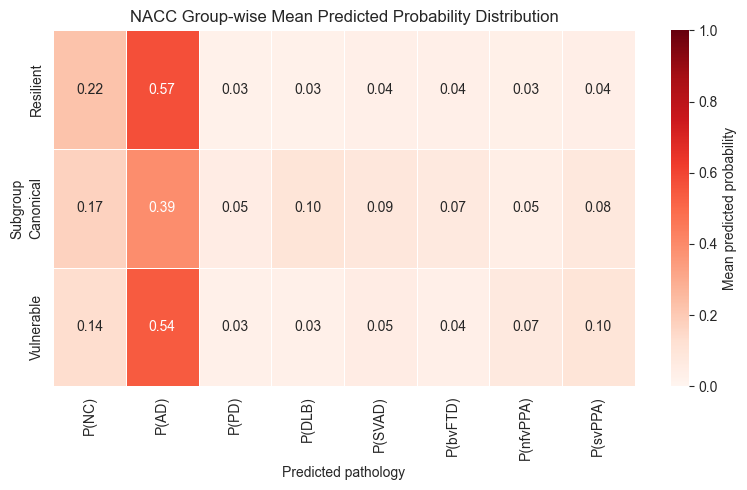

In [101]:
group_means = (
    plot_df
    .groupby(group_col)[prob_cols]
    .mean()
    .reindex(group_order)
)

# ------------------------------------------------------------
# Plot heatmap
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))

sns.heatmap(
    group_means,
    cmap="Reds",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Mean predicted probability"}
)

plt.xlabel("Predicted pathology")
plt.ylabel("Subgroup")
plt.title("NACC Group-wise Mean Predicted Probability Distribution")

plt.tight_layout()

plt.show()

C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_28100\3269812920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[group_col] = pd.Categorical(


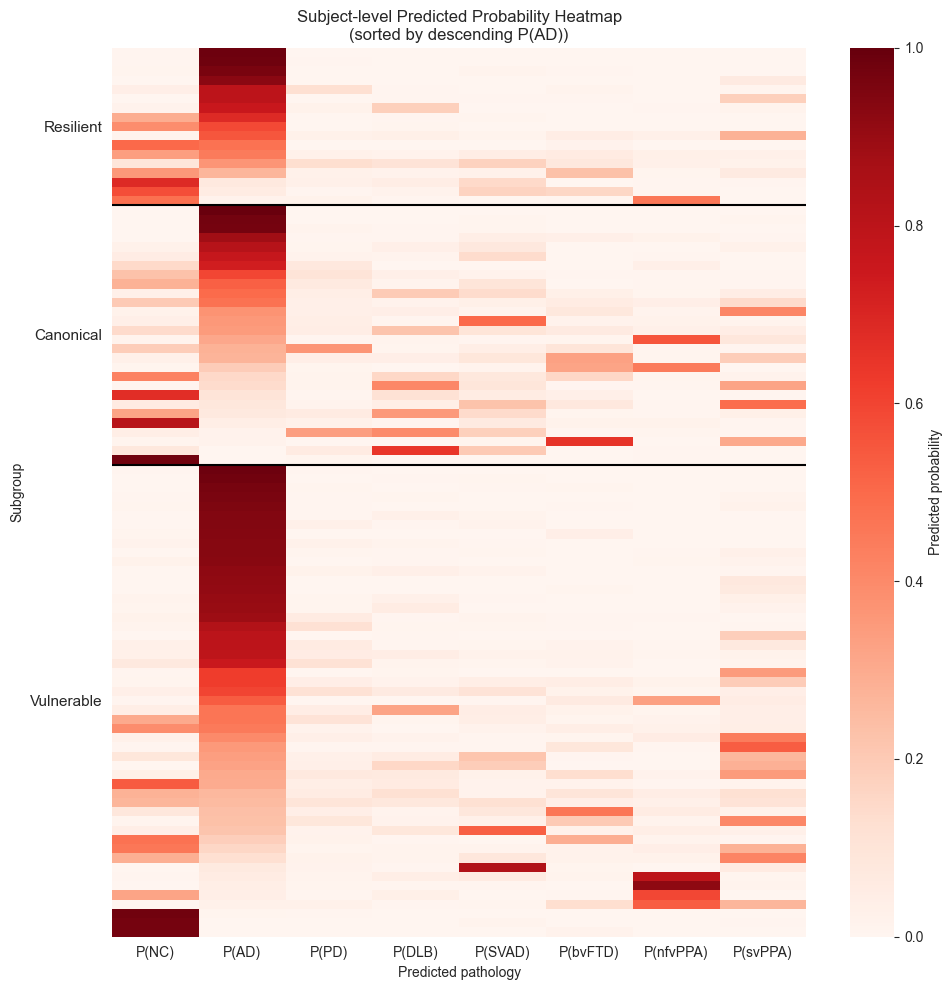

In [102]:
# ------------------------------------------------------------
# Sort: group first, then descending P(AD)
# ------------------------------------------------------------
plot_df[group_col] = pd.Categorical(
    plot_df[group_col],
    categories=group_order,
    ordered=True
)

nacc_sorted = (
    plot_df
    .sort_values([group_col, "P(AD)"], ascending=[True, False])
    .reset_index(drop=True)
)


heatmap_data = nacc_sorted[prob_cols]

# ------------------------------------------------------------
# Compute group positions for y-axis labels
# ------------------------------------------------------------
group_counts = (
    nacc_sorted[group_col]
    .value_counts()
    .reindex(group_order)
)


group_centers = {}
start = 0

for grp, count in group_counts.items():
    center = start + count / 2
    group_centers[grp] = center
    start += count

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(10, 10))

ax = sns.heatmap(
    heatmap_data,
    cmap="Reds",
    vmin=0,
    vmax=1,
    yticklabels=False,
    cbar_kws={"label": "Predicted probability"}
)

# ------------------------------------------------------------
# Horizontal lines between groups
# ------------------------------------------------------------
cum_sizes = np.cumsum(group_counts.values)

for y in cum_sizes[:-1]:
    ax.hlines(y, *ax.get_xlim(), colors="black", linewidth=1.5)

# ------------------------------------------------------------
# TN subgroup labels on y-axis
# ------------------------------------------------------------
ax.set_yticks(list(group_centers.values()))
ax.set_yticklabels(list(group_centers.keys()), rotation=0, fontsize=11)

# ------------------------------------------------------------
# Labels
# ------------------------------------------------------------
ax.set_xlabel("Predicted pathology")
ax.set_ylabel("Subgroup")
ax.set_title("Subject-level Predicted Probability Heatmap\n(sorted by descending P(AD))")

plt.tight_layout()
plt.show()

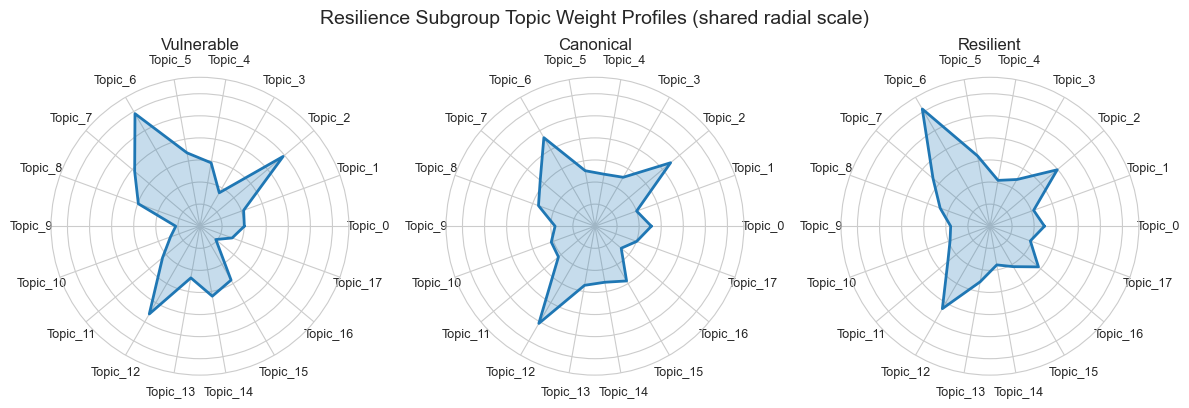

In [103]:
topic_cols = [c for c in plot_df.columns if c.startswith("Topic_")]

groups = plot_df[group_col].unique()
n_groups = len(groups)
n_topics = len(topic_cols)

# ------------------------------------------------------------
# Global max for shared axis
# ------------------------------------------------------------
global_max = (
    plot_df
    .groupby(group_col)[topic_cols]
    .mean()
    .values
    .max()
)

# ------------------------------------------------------------
# Radar setup
# ------------------------------------------------------------
angles = np.linspace(0, 2 * np.pi, n_topics, endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

fig, axes = plt.subplots(
    1, n_groups,
    figsize=(4 * n_groups, 4),
    subplot_kw=dict(polar=True)
)

if n_groups == 1:
    axes = [axes]

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
# for ax, grp in zip(axes, groups):
for ax, grp in zip(axes, ['Vulnerable', 'Canonical', 'Resilient']):

    grp_df = plot_df[plot_df[group_col] == grp]
    mean_topics = grp_df[topic_cols].mean().values
    mean_topics = np.concatenate([mean_topics, [mean_topics[0]]])

    ax.plot(angles, mean_topics, linewidth=2)
    ax.fill(angles, mean_topics, alpha=0.25)

    ax.set_title(grp, pad=20)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(topic_cols, fontsize=9)

    ax.set_ylim(0, global_max * 1.1)   # ✅ shared scale
    ax.set_yticklabels([])

plt.suptitle("Resilience Subgroup Topic Weight Profiles (shared radial scale)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
## NACC vulnerable check
print('VULN')
r2 = nacc_results[nacc_results[group_col]=='Vulnerable']
print(r2['DX'].value_counts())
print('\nRESIL')
r2 = nacc_results[nacc_results[group_col]=='Resilient']
print(r2['DX'].value_counts())
print('\nCANON')
r2 = nacc_results[nacc_results[group_col]=='Canonical']
print(r2['DX'].value_counts())

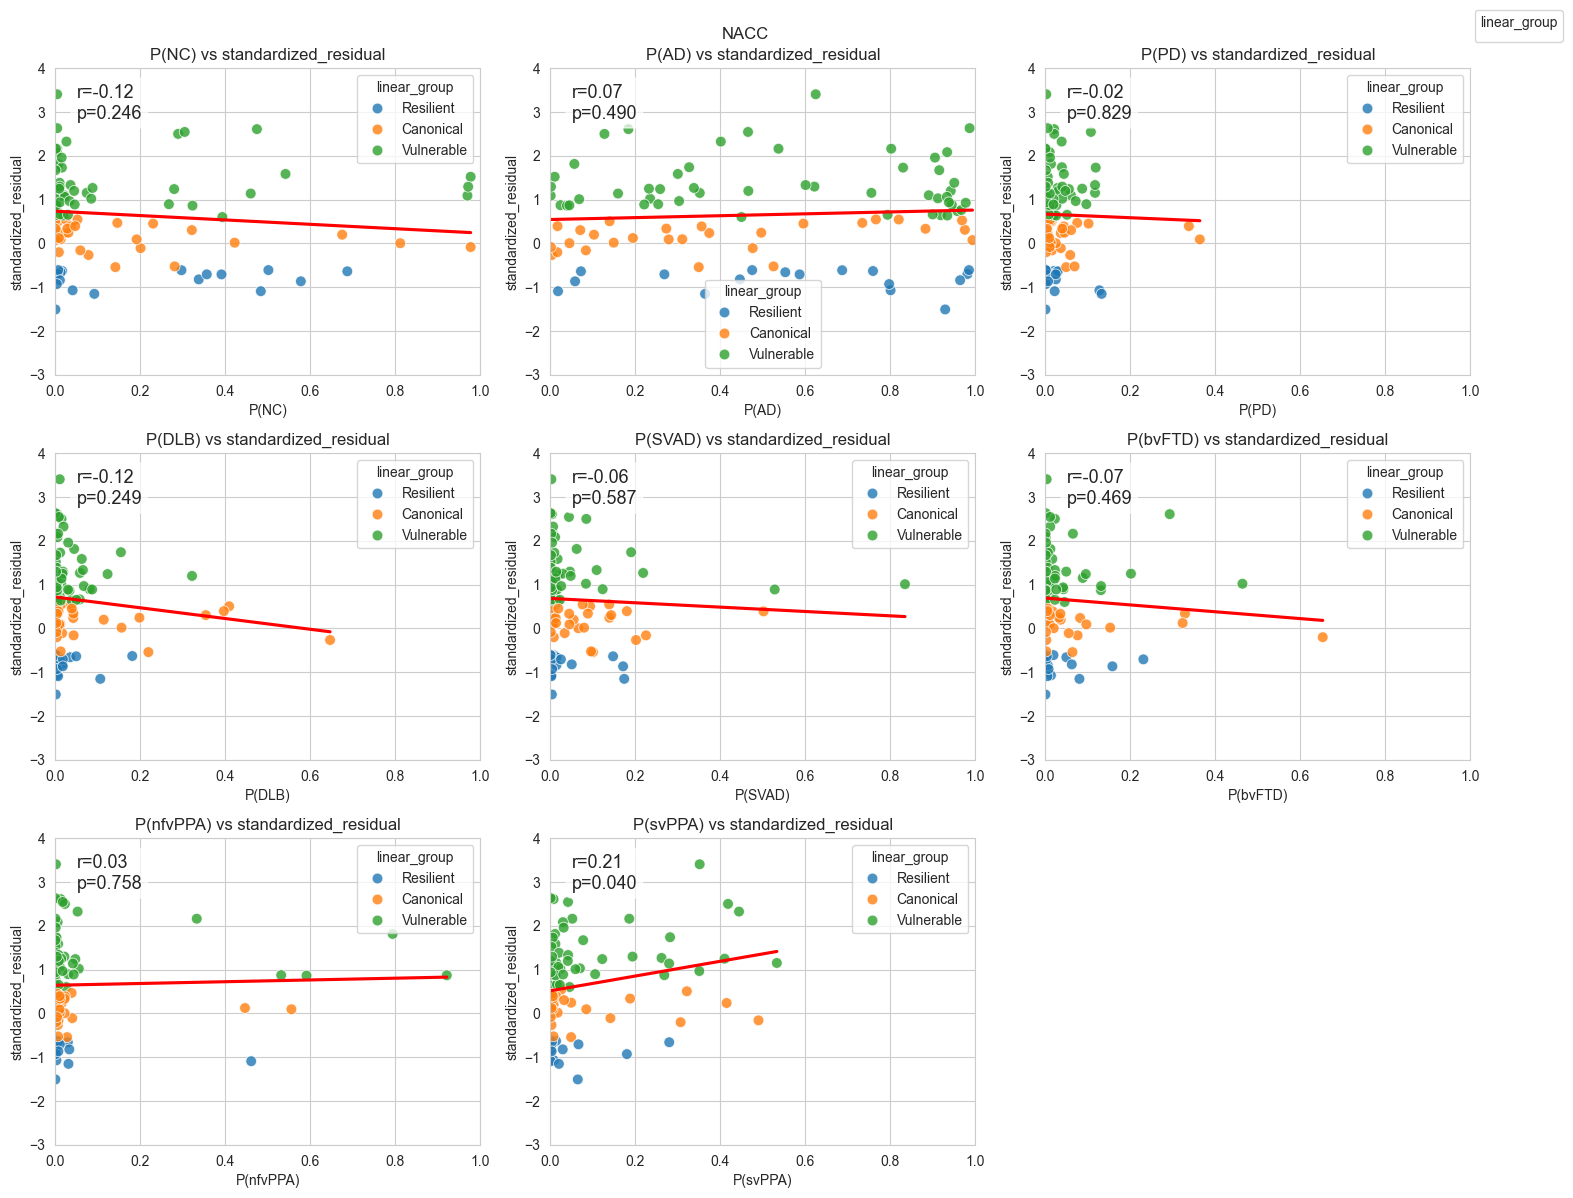

In [104]:
## Correlation Subplots ##
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr  # or spearmanr if you prefer
import numpy as np

# -----------------------------
# Example inputs
# -----------------------------
# plot_df: your dataframe
# cols_to_corr: list of columns of probabilities to correlate
# target_col: column to correlate against
cols_to_corr = prob_cols
target_col = 'standardized_residual'  # for example

# -----------------------------
# Plotting setup
# -----------------------------
n_cols = 3  # how many subplots per row
n_rows = int(np.ceil(len(cols_to_corr) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()
palette = sns.color_palette("tab10", n_colors=len(group_order))

group_palette = dict(zip(group_order, palette))

for ax, col in zip(axes, cols_to_corr):
    
    x = plot_df[col]
    y = plot_df[target_col]
    
    # Compute correlation
    r, p = pearsonr(x, y)
    
    # Scatter plot
    sns.scatterplot(
        x=x, y=y, hue=plot_df[group_col], palette=group_palette, ax=ax, s=60, alpha=0.8
    )
    
    # Fit line
    sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', ci=None)
    
    # Annotate r and p
    ax.text(0.05, 0.95, f"r={r:.2f}\np={p:.3f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
            fontsize = 13)
    
    ax.set_xlabel(col)
    ax.set_ylabel(target_col)
    ax.set_title(f"{col} vs {target_col}")
    ax.set_xlim([0, 1])
    ax.set_ylim([-3, 4])

# Remove empty axes if any
for ax in axes[len(cols_to_corr):]:
    ax.remove()
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right', title=group_col, bbox_to_anchor=(1.05, 1))
plt.suptitle('NACC')
plt.tight_layout()
plt.show()